# GSEA & annData
Often it is really informative and useful to be able to run gene enrichment analysis on an annData object to see what pathways or signatures are enriched in certain clusters compared to others. There are packages that can be coerced to do this but they are not always straightforward to use. The purpose of this notebook is to show you how to run GSEA on your scRNAseq data and visualize the enichment results. We have made these tasks _extremely_ easy through the use of our helper functions that seamlessly interface to [GSEAPY](https://gseapy.readthedocs.io/en/latest/) for the analysis, and through the use of our visualization functions.

## Data
The training data is a subset of the mouse gastrulation atlas described in [Pijuan-Sala et al Nature 2019](https://www.nature.com/articles/s41586-019-0933-9). We have reduced the size of this dataset to make running this tutorial more accessible. We have also re-annotated the cell lineages based on recent spatial transcriptomics studies of mouse gastrulation (see [Lohoff et al 2021](https://www.nature.com/articles/s41587-021-01006-2) and [Kumar et al 2023](https://www.nature.com/articles/s41588-023-01435-6)). 

- You can download the h5ad file from [here](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/training/mouseGastrulation_n75_032124.h5ad)
- There are 1,875 cells
- 29,452 genes
- 25 cell types or lineages
- Sampled from embryonic stages E6.5 to E8.5

## Gene signatures
In this notebook, we will onyl use the mouse [MSigDB Hallmarks](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/mh.all.v2023.2.Mm.symbols.gmt) as described [here](https://www.gsea-msigdb.org/gsea/msigdb/mouse/collections.jsp) but any appropriate .gmt file can be used. Below are some additional gene signature sets that we have cobbled together from various sources and that are useful in developmental and stem cell systems:
- [Signaling pathway effector targets](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/Signaling_Targets_ChipAtlas_102222.gmt) that [we previously curated](https://pubmed.ncbi.nlm.nih.gov/35090587/) from [Chip-Atlas](https://chip-atlas.org/)
- [Signaling pathways in development](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/SIGNALING_v7.4_101322.gmt)
- [GOBP development subset](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/GOBP_Development_v7.4_101322.gmt)

# Steps to GSEA

## Load packages

In [1]:
import scanpy as sc
from joblib import dump, load
import numpy as np
import pandas as pd
import pySingleCellNet as pySCN
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

import warnings
warnings.filterwarnings('ignore')
sc.settings.verbosity = 0

## Load gene signatures

In [11]:
hallmarks = pySCN.read_gmt("mh.all.v2023.2.Mm.symbols.gmt")

## Load data
Then subject it to the usual processing pipeline. Low quality cell barcodes have alread been removed.

In [2]:
adata = sc.read_h5ad("mouseGastrulation_n75_032124.h5ad")
adata = pySCN.mito_rib(adata, species='MM', clean=True)
min_num_cells = 37
sc.pp.filter_genes(adata, min_cells=min_num_cells)

## Norm/HVG/PCA

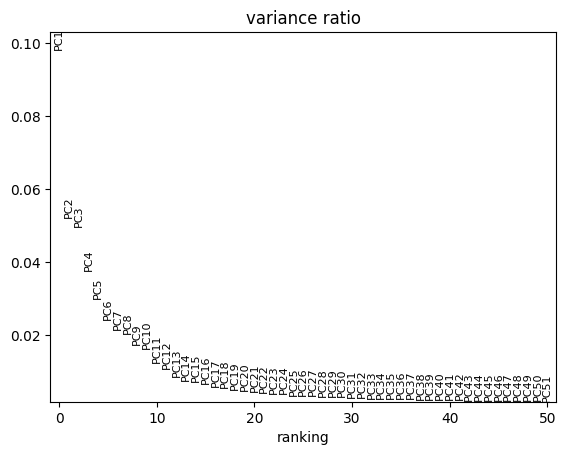

In [3]:
adNorm = pySCN.norm_hvg_scale_pca(adata)
sc.pl.pca_variance_ratio(adNorm, 50)

## kNN/Cluster/UMAP

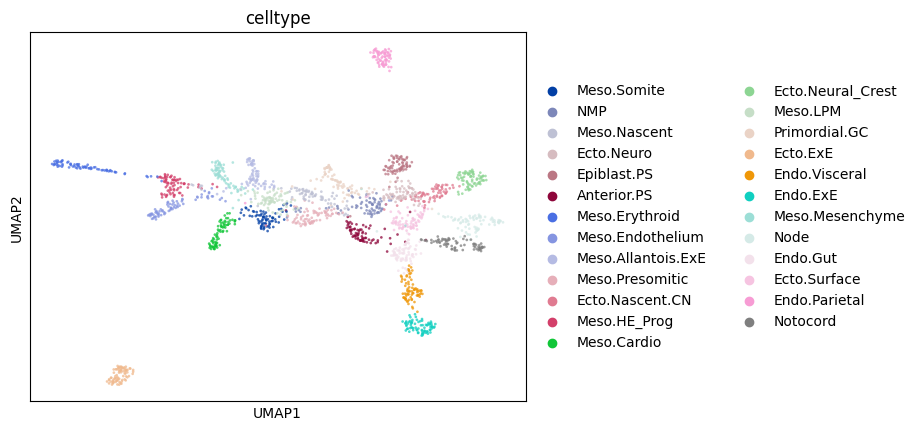

In [4]:
n_pcs = 30
n_neighbors = 30

sc.pp.neighbors(adNorm, n_neighbors=n_neighbors, n_pcs=n_pcs)

sc.tl.leiden(adNorm,.1)
sc.tl.paga(adNorm)
sc.pl.paga(adNorm, plot=False)
sc.tl.umap(adNorm, init_pos='paga')
sc.pl.umap(adNorm,color=['celltype'], alpha=.75, s=15)

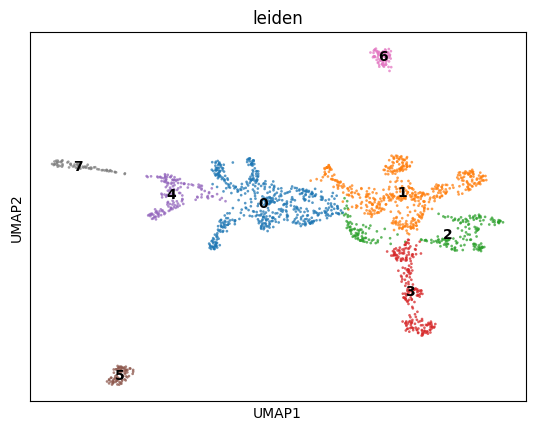

In [5]:
sc.pl.umap(adNorm,color=['leiden'], alpha=.75, s=15, legend_loc='on data')

## Annotate these 'coarse' clusters
The low Leiden resolution resulted in coarse clustering roughly corresponding:
- Erythrocyte (7)
- Endothelial, hemogenic endothelium (4)
- Mesoderm (0)
- Ectoderm, Epiblast, Primordial germ cell (1)
- APS, Node and Notochord (2)
- Endoderm (3)
- Extra-embryonic ectoderm (5)
- Parietal endoderm (6).

cell_dict = {'Erythrocyte': ['7'],
             'HE, endothelial': ['4'],
             'Mesoderm': ['0'],
             'Ectoderm, Epiblast, PGC': ['1'],
             'APS, Node, Notochord': ['2'],
             'Endoderm ': ['3'],
             'ExE Ectoderm': ['5'],
             'Parietal Endoderm': ['6']
}

new_obs_name = 'coarse_cluster'
adNorm.obs[new_obs_name] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adNorm.obs.leiden).isin(cell_dict[i])
    adNorm.obs.loc[ind,new_obs_name] = i

adNorm.obs[new_obs_name] = adNorm.obs[new_obs_name].astype("category") 

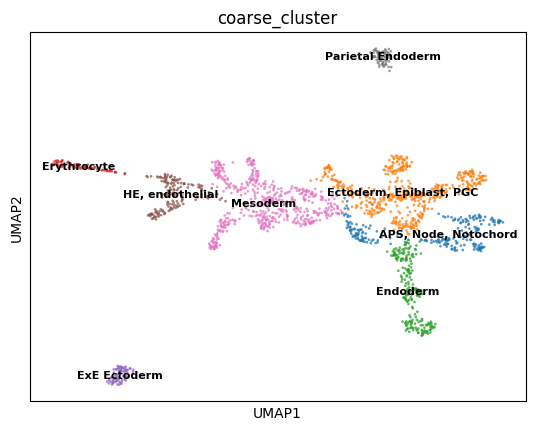

In [7]:
sc.pl.umap(adNorm,color=[new_obs_name], alpha=.75, s=15, legend_loc='on data', legend_fontsize=8)

## Analysis of coarse clusters
In the next few steps, we will run differentiation gene expression analysis and then GSEA to identify genes and pathways enriched in these broadly annotated cell groups.

### Differential gene expression (DEG) analysis - coarse

In [8]:
sc.tl.rank_genes_groups(adNorm, use_raw=False, groupby="coarse_cluster")

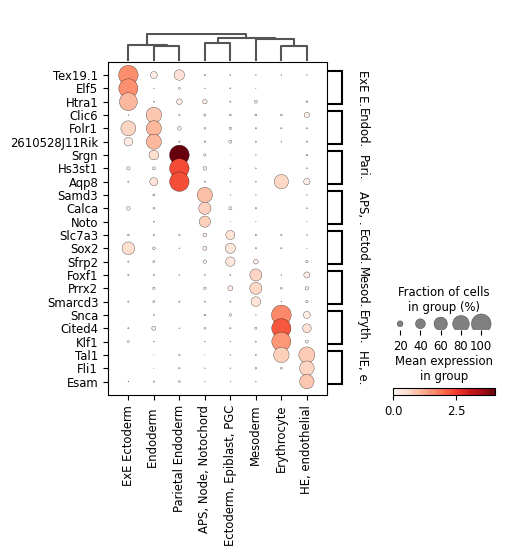

In [10]:
sc.tl.filter_rank_genes_groups(adNorm, min_fold_change=.5, min_in_group_fraction=.3, max_out_group_fraction=.1)

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=3, groupby="coarse_cluster", dendrogram=True, key='rank_genes_groups_filtered', swap_axes=True, ax=ax)

Note to self: re-work the figure above so that cell group labels on x-axis are rotated 45, and remove the gene-group labes on the y-axis. Probably can do so by extracting vars, then passing to sc.pl.DotPot.

### GSEA

In [12]:
deg_res = pySCN.convert_diffExp_to_dict(adNorm)
gsea_res = pySCN.gsea_on_deg(deg_res, "hallmarks",genesets = hallmarks, permutation_num = 1e3)

2024-03-21 17:44:34,340 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-21 17:44:37,130 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


### Heatmap GSEA results

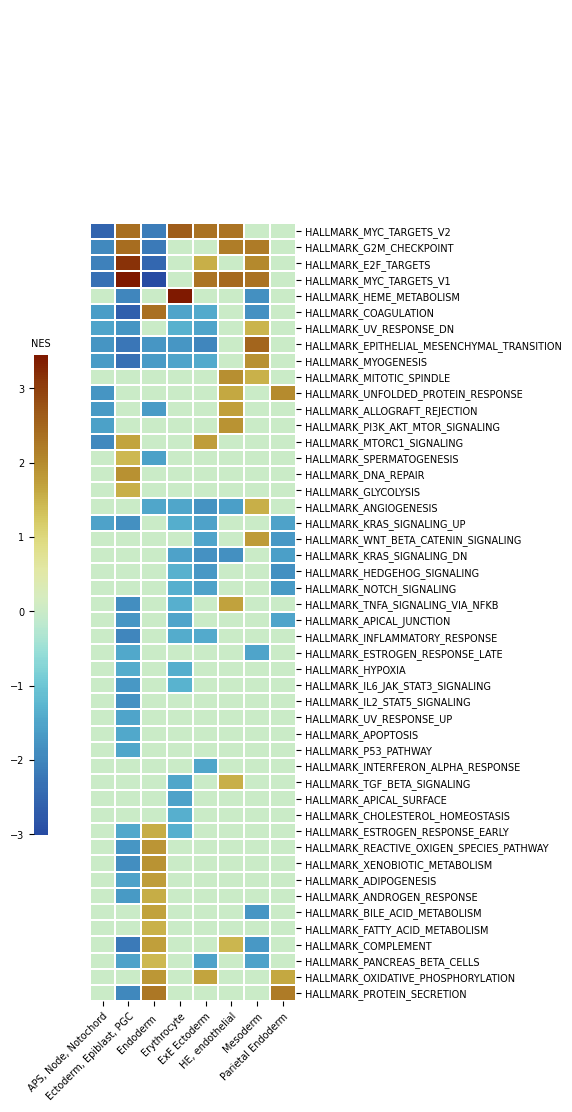

In [13]:
gsea_matrix_coarse = pySCN.collect_gsea_results_from_dict(gsea_res, .05)
pySCN.heatmap_gsea(gsea_matrix_coarse, figsize=(7,12),clean_signatures = True, clean_cells=True)

## Analysis of cell types
Here, we will run DEG and GSEA based on the more finely resolved cell annotations that were provided with the data.

### DEG

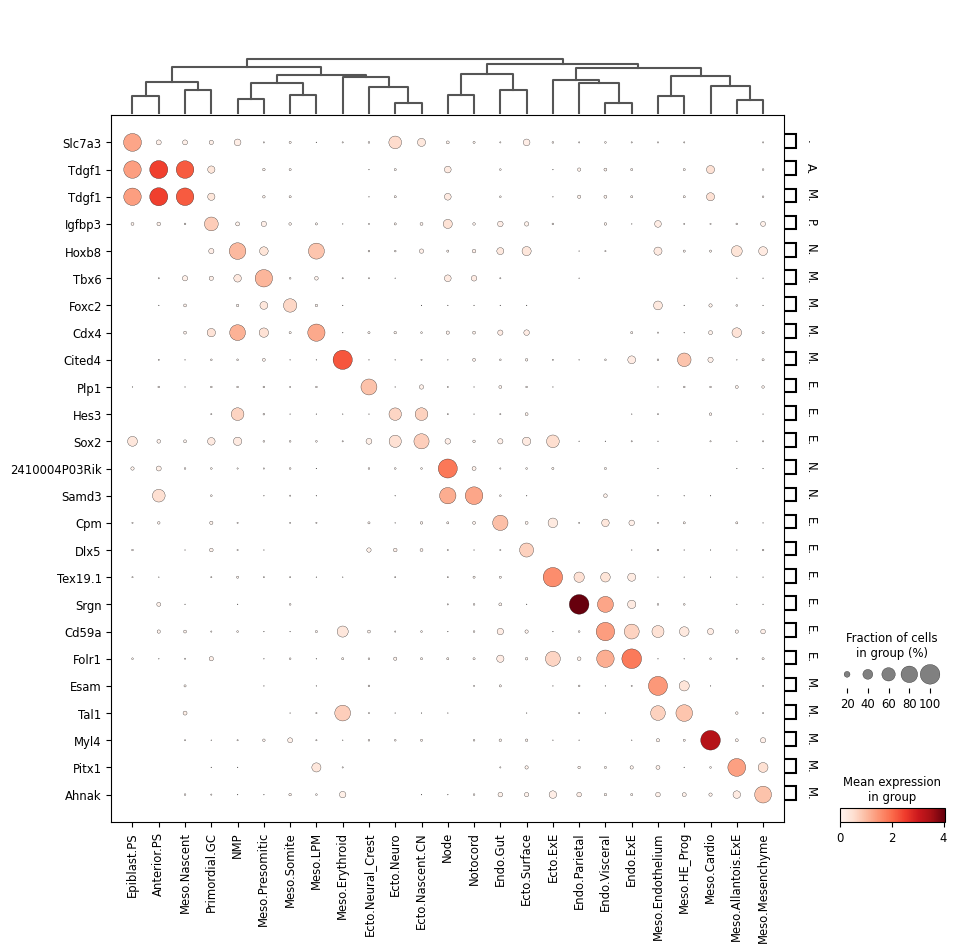

In [14]:
sc.tl.rank_genes_groups(adNorm, use_raw=False, groupby="celltype")
sc.tl.filter_rank_genes_groups(adNorm, min_fold_change=.5, min_in_group_fraction=.5, max_out_group_fraction=.15)
sc.tl.dendrogram(adNorm, "celltype")
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=1, groupby="celltype", dendrogram=True, key='rank_genes_groups_filtered', swap_axes=True)

### GSEA

In [15]:
deg_res_ct = pySCN.convert_diffExp_to_dict(adNorm)
gsea_res_ct = pySCN.gsea_on_deg(deg_res_ct, "hallmarks",genesets = hallmarks, permutation_num = 1e3)

2024-03-21 17:44:51,532 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-21 17:44:52,418 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-21 17:44:53,323 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-21 17:44:54,224 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-21 17:44:56,031 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-21 17:44:57,850 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

### Heatmap GSEA results

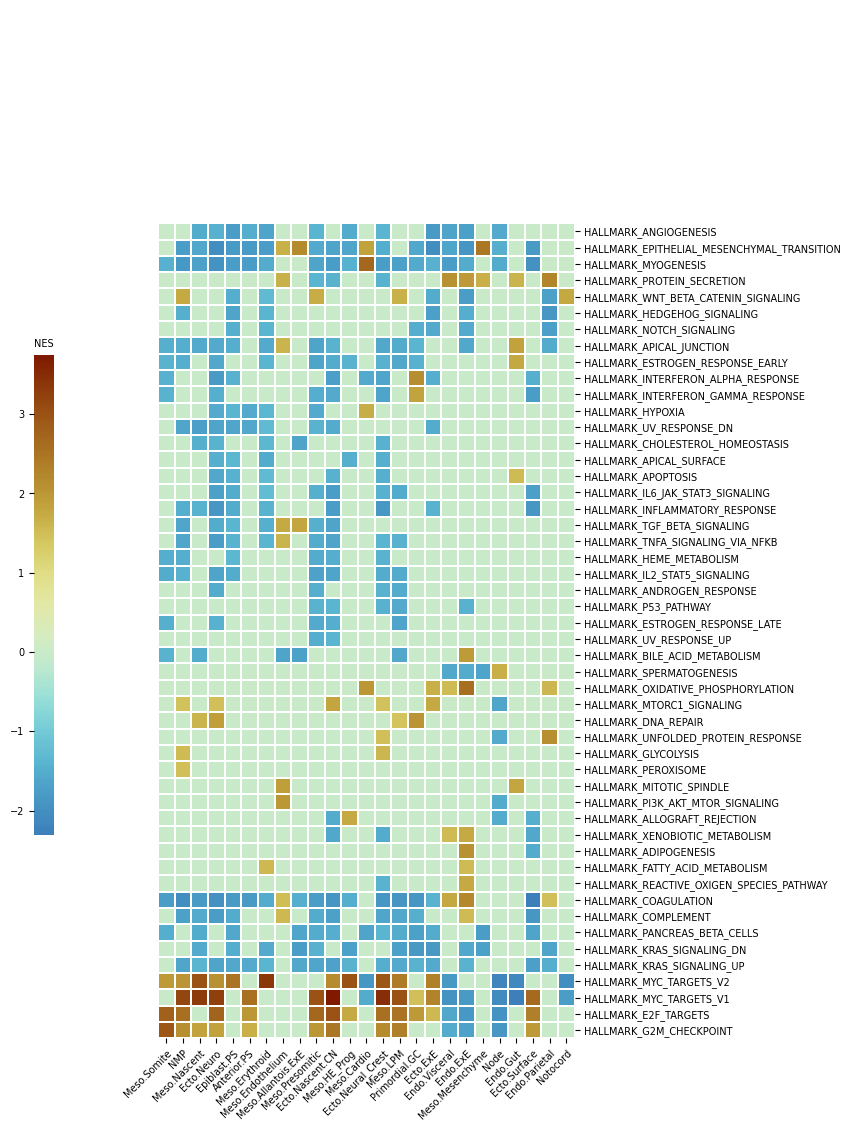

In [16]:
gsea_matrix_ct = pySCN.collect_gsea_results_from_dict(gsea_res_ct, .05)
pySCN.heatmap_gsea(gsea_matrix_ct, figsize=(10,12),clean_signatures = True, clean_cells=True)